## Analyzing 2021 FCC Data 

This notebook contains the code used to wrangle, join, and analyze the [Fixed Broadband Deployment Data](https://www.fcc.gov/general/broadband-deployment-data-fcc-form-477) from FCC Form 477. 

All csv files can be found in the "data" folder of the [working](https://github.com/danielgrzenda/broadbandequity/tree/working) branch of our Broadband Equity Github repo.

##### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import data_pipeline.spatial_operations as so
import data_pipeline.fetch_census_data as fetch_census

##### Importing Chicago FCC data

First, we use the FCC IL Dec 2020 csv file (which can be found [here](https://us-fcc.app.box.com/v/IL-Dec2020-v1) or written locally using `fetch_fcc_data.py`). Since it is a large file and we only want data on Chicago, we filter for Cook County data only and then export it as a new csv file which is saved in the "data" folder. **DO NOT RUN THE FOLLOWING CHUNKS OF CODE!!!**

In [2]:
%%script false --no-raise-error

# FCC IL

fcc_df = pd.read_csv("../../IL-Fixed-Dec2020-v1.csv",
                     index_col=0,parse_dates=[0])

In [3]:
%%script false --no-raise-error

#changing BlockCode column to string type

fcc_df['BlockCode']=fcc_df['BlockCode'].astype(str)

In [4]:
%%script false --no-raise-error

# Extracting state, county, tract, block numbers from BlockCode column
# IL state=17
# Cook County=031

fcc_df['state'] = fcc_df['BlockCode'].str[:2]
fcc_df['county'] = fcc_df['BlockCode'].str[2:5]
fcc_df['tract'] = fcc_df['BlockCode'].str[5:11]
fcc_df['block'] = fcc_df['BlockCode'].str[-4:]

In [5]:
%%script false --no-raise-error

# Filtering for Cook County only 
# 3408835 -> 763788 rows

chi_fcc = fcc_df[(fcc_df.county == "031")]

In [6]:
%%script false --no-raise-error

# Filtering for Chicago only
# 763788 -> 759684 rows

chi_fcc = chi_fcc.astype({'block':'int64'})
chicago_blocks = pd.read_csv("../../ChicagoCensusBlocks.csv").BLOCKCE10
chi_fcc = chi_fcc[chi_fcc.block.isin(chicago_blocks)]


In [7]:
%%script false --no-raise-error

# export final dataframe to csv file

chi_fcc.to_csv(r'data/chi_fcc.csv', index = False)

In [8]:
%%script false --no-raise-error

# final dataframe looks like this
chi_fcc.head(5)

Don't accidentally commit chi_fcc.csv to the repository!! (It's too large - added to `gitignore` for that reason!)

##### Analysis

In [9]:
chi_fcc = pd.read_csv("data/chi_fcc.csv",index_col=0,parse_dates=[0])
chi_fcc.head()

,FRN,ProviderName,DBAName,HoldingCompanyName,HocoNum,HocoFinal,StateAbbr,BlockCode,TechCode,Consumer,MaxAdDown,MaxAdUp,Business,state,county,tract,block
Provider_Id,,,,,,,,,,,,,,,,,
69644,7097355,"TOWERSTREAM, INC.",Towerstream,"Towerstream, Inc.",190373,"Towerstream, Inc.",IL,170310207023015,70,0,0.0,0.0,1,17,31,20702,3015
69644,7097355,"TOWERSTREAM, INC.",Towerstream,"Towerstream, Inc.",190373,"Towerstream, Inc.",IL,170310803004005,70,0,0.0,0.0,1,17,31,80300,4005
69644,7097355,"TOWERSTREAM, INC.",Towerstream,"Towerstream, Inc.",190373,"Towerstream, Inc.",IL,170310810005003,70,0,0.0,0.0,1,17,31,81000,5003
69644,7097355,"TOWERSTREAM, INC.",Towerstream,"Towerstream, Inc.",190373,"Towerstream, Inc.",IL,170310813003001,70,0,0.0,0.0,1,17,31,81300,3001
69644,7097355,"TOWERSTREAM, INC.",Towerstream,"Towerstream, Inc.",190373,"Towerstream, Inc.",IL,170310815002006,70,0,0.0,0.0,1,17,31,81500,2006


In [10]:
# drop columns we don't need
chi_fcc = chi_fcc.reset_index()[["DBAName","HocoNum","TechCode","Consumer","MaxAdDown","MaxAdUp","tract","block"]]
chi_fcc.head()

,DBAName,HocoNum,TechCode,Consumer,MaxAdDown,MaxAdUp,tract,block
0,Towerstream,190373,70,0,0.0,0.0,20702,3015
1,Towerstream,190373,70,0,0.0,0.0,80300,4005
2,Towerstream,190373,70,0,0.0,0.0,81000,5003
3,Towerstream,190373,70,0,0.0,0.0,81300,3001
4,Towerstream,190373,70,0,0.0,0.0,81500,2006


This data includes satellite.

From FCC documentation:
- FRN: FCC registration number
- DBAName: Name doing business as
- HocoNum: holding company number
- TechCode: technology of transmission (https://www.fcc.gov/general/technology-codes-used-fixed-broadband-deployment-data)
- Consumer: (0/1) where 1 = Provider can or does offer consumer/mass market/residential service in the block
- MaxAdDown: Maximum advertised downstream speed/bandwidth (in Mbps) offered by the provider in the block for Consumer service
- MaxAdUp: Maximum advertised upstream speed/bandwidth (in Mbps) offered by the provider in the block for Consumer service

One reason why it's a good idea for us to bring in technology of transmission is that providers submit one record per tract _per technology_ (along with that technology's up/down speed) (Source: FAQ https://transition.fcc.gov/form477/477faqs.pdf). 

In [11]:
print(f"Average proportion of total blocks with residential service offered per provider: {int(chi_fcc.Consumer.mean()*100)}%")

Average proportion of total blocks with residential service offered per provider: 83%


The Consumer mean number doesn't tell us much. The reason is that, per the Form 477 instructions https://us-fcc.app.box.com/v/Form477Instructions, ISPs report "all census blocks in which the filer (including affiliates) makes broadband connections available to end-user premises". That means that ISPs DON'T report blocks that they don't make broadband connections available. So the 83% just means that in 17% of provider-block combinations, the provider makes broadband connections available but doesn't offer residential service; it doesn't tell us anything about the other providers who don't offer service. (Also note that providers don't have to report blocks where they offer non-broadband internet, defined as less than 200 kbps.)

We don't want to include Consumer=0 blocks in our analysis; we're confining our analysis here to the speed of internet where it is at least offered residentially. So we'll filter our dataset to remove Consumer=0 rows. (Note that later on we will be able to see if there are populated Chicago-area blocks with no residential internet service.)

In [12]:
chi_fcc = chi_fcc[chi_fcc.Consumer==1][["DBAName","HocoNum","TechCode","MaxAdDown","MaxAdUp","tract","block"]]
chi_fcc

,DBAName,HocoNum,TechCode,MaxAdDown,MaxAdUp,tract,block
15273,Verizon Wireless,131425,70,300.0,50.0,10701,1014
15274,Verizon Wireless,131425,70,300.0,50.0,30200,3005
15275,Verizon Wireless,131425,70,300.0,50.0,30706,1011
15276,Verizon Wireless,131425,70,300.0,50.0,30900,2000
15277,Verizon Wireless,131425,70,300.0,50.0,31400,3003
...,...,...,...,...,...,...,...
759679,"VSAT Systems, LLC.",300167,60,2.0,1.3,980100,1006
759680,"VSAT Systems, LLC.",300167,60,2.0,1.3,980100,1007
759681,"VSAT Systems, LLC.",300167,60,2.0,1.3,980100,1008
759682,"VSAT Systems, LLC.",300167,60,2.0,1.3,980100,1009


In [13]:
print(f"Number of unique DBAS: {len(set(chi_fcc.DBAName))}")
print(f"Number of unique holding companies: {len(set(chi_fcc.HocoNum))}")
print(f"Number of tracts: {len(set(chi_fcc.tract))}")
print(f"Number of blocks: {len(set(chi_fcc.block))}")


Number of unique DBAS: 34
Number of unique holding companies: 34
Number of tracts: 1318
Number of blocks: 651


In [14]:
# to look further at providers, we will remove rows representing one providers's multiple technologies in one block
remove_tech = chi_fcc.drop(columns=["TechCode"]).drop_duplicates()

# proportion of each provider (by business name)
print('Percent of block-provider entries made up of each provider')
round(remove_tech.DBAName.value_counts(normalize=True)*100,1)
# remove_tech.HocoNum.value_counts()
# note: the above line returns essentially the same table; each DBA company has a unique holding company

Percent of block-provider entries made up of each provider


AT&T Illinois                        28.1
Viasat Inc                           15.5
VSAT Systems, LLC.                   15.4
HughesNet                            15.4
Comcast                              13.3
T-Mobile                              6.8
WOW                                   2.6
RCN                                   2.2
e-vergent.com, LLC                    0.4
XLBroadband                           0.2
Everywhere Wireless, LLC              0.1
Webpass, Inc.                         0.0
Surf Broadband Solutions              0.0
Verizon Wireless                      0.0
DLS Computer Services                 0.0
Urban Communications                  0.0
12Global                              0.0
UpstreamNetwork                       0.0
Cable ONE                             0.0
Mediacom Illinois LLC                 0.0
Future Link IT                        0.0
MidwestTelecomofAmerica               0.0
One Ring Networks                     0.0
Consolidated Communications       

This indicates that there are 34 different companies offering broadband in the Chicago area. However, 8 companies make up more than 99% of the provider-block entries: AT&T Illinois, Viasat, VSAT, HughesNet, Comcast, T-Mobile, WOW, and RCN.

Note: Unlike all the others, I can barely find anything about "VSAT Systems, LLC." online. It also has precisely the same number of entries as HughesNet, which makes me wonder whether it's somehow related to them in a contractual relationship or something similar.

In [15]:
# note we can drop holding companies column as we determined it's equivalent to DBA Name

chi_fcc = chi_fcc[["DBAName","TechCode","MaxAdDown","MaxAdUp","tract","block"]]

Now let's take a closer look at the technologies involved.

In [16]:
# to look further at technologies, we will remove rows representing one technology's multiple providers in one block
remove_providers = chi_fcc.drop(columns=["DBAName"]).drop_duplicates()

# proportion of each TechCode (see next chunk for explanations)
remove_providers.TechCode.value_counts(normalize=True)

60    0.463553
43    0.139280
11    0.127200
12    0.094232
70    0.075392
42    0.039187
50    0.032198
10    0.028388
41    0.000424
30    0.000117
20    0.000024
0     0.000003
40    0.000002
Name: TechCode, dtype: float64

In [17]:
fcc_grouptech = chi_fcc.groupby(["TechCode"])

# average speeds by tech type
tech_summary = round(fcc_grouptech.mean()[["MaxAdDown","MaxAdUp"]])

# add the proportions of provider-blocks with technology
tech_summary["% of total"] = round(remove_providers.TechCode.value_counts(normalize=True).sort_index()*100,2)
tech_summary = tech_summary.sort_values(by=["% of total"],ascending=False)

# rename for clarity
tech_names = {
    0: "unknown",10:"copper line (asym xDSL)",11:"copper line (ADSL)",12:"copper line (VDSL)",20:"copper line (sym xDSL)",30:"copper line (other)",
    40:"cable modem (other)",41:"cable modem (DOCSIS 1-2)",42:"cable modem (DOCSIS 3.0)",43:"cable modem (DOCSIS 3.1)",50:"optical fiber",60:"satellite",70:"terrestrial fixed wireless"
    }
tech_summary = tech_summary.rename(index=tech_names)

tech_summary

,MaxAdDown,MaxAdUp,% of total
TechCode,,,
satellite,24.0,2.0,46.36
cable modem (DOCSIS 3.1),1000.0,34.0,13.93
copper line (ADSL),16.0,1.0,12.72
copper line (VDSL),84.0,17.0,9.42
terrestrial fixed wireless,36.0,12.0,7.54
cable modem (DOCSIS 3.0),832.0,40.0,3.92
optical fiber,1000.0,1000.0,3.22
copper line (asym xDSL),4.0,0.0,2.84
cable modem (DOCSIS 1-2),25.0,4.0,0.04


Clearly, technology type has a _big_ influence on internet speed. 

Also note that MaxAdDown and MaxAdUp generally track each other; optical fiber has *much* faster MaxAdUp than the other technology types.

How much variation in internet speed is there among each technology?

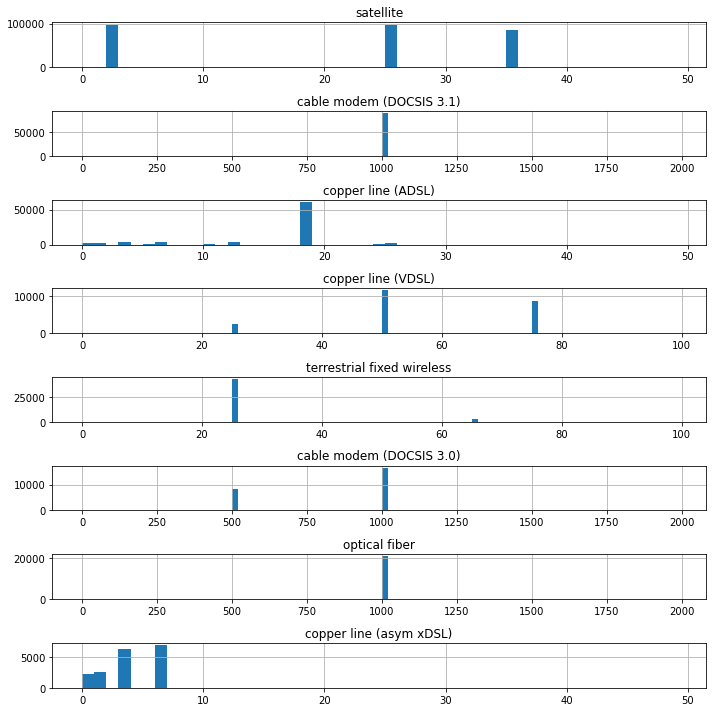

In [18]:
print("Warning: Differently-scaled x axes")

plt.rcParams['figure.figsize'] = [10, 10]  # add more space
fig, axes = plt.subplots(8, 1)
chi_fcc[chi_fcc.TechCode==60].hist("MaxAdDown",bins=range(0,50,1),ax=axes[0])
chi_fcc[chi_fcc.TechCode==43].hist("MaxAdDown",bins=range(0,2000,20),ax=axes[1])
chi_fcc[chi_fcc.TechCode==11].hist("MaxAdDown",bins=range(0,50,1),ax=axes[2])
chi_fcc[chi_fcc.TechCode==12].hist("MaxAdDown",bins=range(0,100,1),ax=axes[3])
chi_fcc[chi_fcc.TechCode==70].hist("MaxAdDown",bins=range(0,100,1),ax=axes[4])
chi_fcc[chi_fcc.TechCode==42].hist("MaxAdDown",bins=range(0,2000,20),ax=axes[5])
chi_fcc[chi_fcc.TechCode==50].hist("MaxAdDown",bins=range(0,2000,20),ax=axes[6])
chi_fcc[chi_fcc.TechCode==10].hist("MaxAdDown",bins=range(0,50,1),ax=axes[7])

techs = [60,43,11,12,70,42,50,10]

for i in range(0,8):
    axes[i].set_title(tech_names[techs[i]])

fig.tight_layout()


We can see that advertised speeds cluster into just a few levels for each technology type. 

Based on these results, we will create dummy variables for the following technology types:
- legacy telephone line (ADSL and asym xDSL): slowest, 16%
- satellite: slow, 46%
- fixed wireless: slow, 8%
- modern telephone line (VDSL): moderate speed, 9%
- modern cable (DOCSIS 3.0 and 3.1): fast, 18%
- fiber: fastest, 3%

In [19]:
tech_names = {
    0: "unknown",10:"copper line (asym xDSL)",11:"copper line (ADSL)",12:"copper line (VDSL)",20:"copper line (sym xDSL)",30:"copper line (other)",
    40:"cable modem (other)",41:"cable modem (DOCSIS 1-2)",42:"cable modem (DOCSIS 3.0)",43:"cable modem (DOCSIS 3.1)",50:"optical fiber",60:"satellite",70:"terrestrial fixed wireless"
    }

chi_fcc["legacy telephone (ADSL, asym xDSL)"] = (chi_fcc["TechCode"]==10)  | (chi_fcc["TechCode"]==11)
chi_fcc["satellite"] = chi_fcc["TechCode"]==60
chi_fcc["fixed wireless"] = chi_fcc["TechCode"]==70
chi_fcc["modern telephone (VDSL)"] = chi_fcc["TechCode"]==12
chi_fcc['modern cable (DOCSIS 3.0, 3.1)'] = (chi_fcc["TechCode"]==42) | (chi_fcc["TechCode"]==43)
chi_fcc['fiber'] = chi_fcc["TechCode"]==50
chi_fcc['other internet'] = (chi_fcc["TechCode"]==0) | (chi_fcc["TechCode"]==20) | (chi_fcc["TechCode"]==30) | (chi_fcc["TechCode"]==40)
chi_fcc.head()

# note that we now have a row per technology per provider per block

,DBAName,TechCode,MaxAdDown,MaxAdUp,tract,block,"legacy telephone (ADSL, asym xDSL)",satellite,fixed wireless,modern telephone (VDSL),"modern cable (DOCSIS 3.0, 3.1)",fiber,other internet
15273,Verizon Wireless,70,300.0,50.0,10701,1014,False,False,True,False,False,False,False
15274,Verizon Wireless,70,300.0,50.0,30200,3005,False,False,True,False,False,False,False
15275,Verizon Wireless,70,300.0,50.0,30706,1011,False,False,True,False,False,False,False
15276,Verizon Wireless,70,300.0,50.0,30900,2000,False,False,True,False,False,False,False
15277,Verizon Wireless,70,300.0,50.0,31400,3003,False,False,True,False,False,False,False


In [20]:
# add an indicator of whether each technology is:
chi_fcc["under 25/3 Mbps"] = (chi_fcc["MaxAdDown"]<25) | (chi_fcc["MaxAdUp"]<3)  # sub-broadband (speed<25/3)
chi_fcc["over 100/20 Mbps"] = (chi_fcc["MaxAdDown"]>=100) & (chi_fcc["MaxAdUp"]>20)  # high-speed (speed>=100/10)
chi_fcc["between 25/3 and 100/20 Mbps"] = (chi_fcc["under 25/3 Mbps"]==0) & (chi_fcc["over 100/20 Mbps"]==0) # broadband (100/10>speed>=25/3)

In [21]:
# before aggregating by block, make sure we don't accidentally combine unique blocks from different tracts
chi_fcc['block'] = chi_fcc['tract'].astype(str)+chi_fcc['block'].astype(str) # (be sure to only run this line once)

In [22]:
fcc_groupblock = chi_fcc.groupby(['block'])

# number of providers of each technology per block
fcc_blocks = fcc_groupblock.sum()

# number of providers total in each block
fcc_blocks["n_providers"] = fcc_groupblock["DBAName"].nunique()

# fix tract numbers
fcc_blocks["tract"] = fcc_groupblock["tract"].first()

# drop unneeded columns
fcc_blocks = fcc_blocks[[
    "tract","legacy telephone (ADSL, asym xDSL)","satellite","fixed wireless","modern telephone (VDSL)",
    "modern cable (DOCSIS 3.0, 3.1)","fiber","other internet","n_providers", "under 25/3 Mbps", "between 25/3 and 100/20 Mbps", "over 100/20 Mbps"
    ]]

fcc_blocks

,tract,"legacy telephone (ADSL, asym xDSL)",satellite,fixed wireless,modern telephone (VDSL),"modern cable (DOCSIS 3.0, 3.1)",fiber,other internet,n_providers,under 25/3 Mbps,between 25/3 and 100/20 Mbps,over 100/20 Mbps
block,,,,,,,,,,,,
1001001000,100100,1,3,0,1,1,0,0,5,2,3,1
1001001001,100100,1,3,0,1,1,1,0,5,2,3,2
1001001002,100100,1,3,0,1,1,1,0,5,2,3,2
1001001003,100100,2,3,0,1,1,1,0,5,3,3,2
1001001004,100100,1,3,0,1,1,0,0,5,2,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9801001006,980100,2,3,1,0,1,0,0,6,3,3,1
9801001007,980100,1,3,0,0,0,0,0,4,2,2,0
9801001008,980100,2,3,0,1,0,0,0,4,3,3,0


Mean providers per block: 5.45
Median providers per block: 6.0
Max providers per block: 10


Text(0.5, 0, 'Number of Internet Providers')

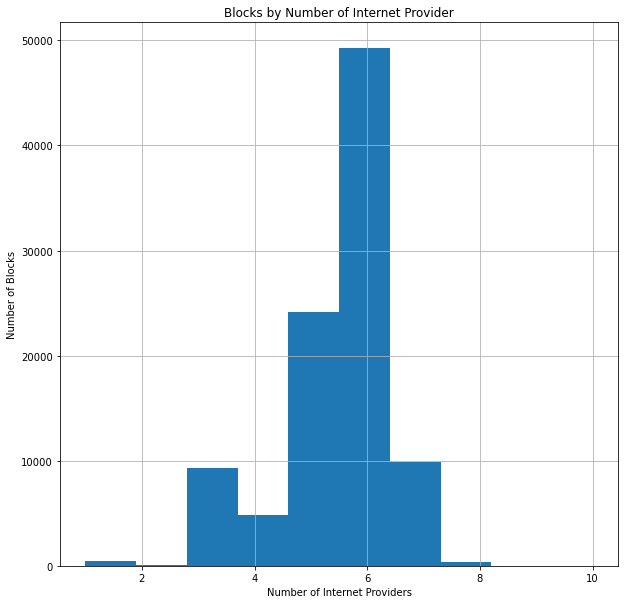

In [23]:
print(f"Mean providers per block: {round(fcc_blocks['n_providers'].mean(),2)}")
print(f"Median providers per block: {round(fcc_blocks['n_providers'].median(),2)}")
print(f"Max providers per block: {round(fcc_blocks['n_providers'].max(),2)}")
fcc_blocks['n_providers'].hist()
plt.title("Blocks by Number of Internet Provider")
plt.ylabel('Number of Blocks')
plt.xlabel('Number of Internet Providers')

In [24]:
print('Percent of blocks with each technology')
round(fcc_blocks[[
    "satellite","legacy telephone (ADSL, asym xDSL)","fixed wireless","modern telephone (VDSL)","modern cable (DOCSIS 3.0, 3.1)","fiber","other internet"
    ]].astype(bool).sum(axis=0)/len(fcc_blocks)*100)

Percent of blocks with each technology


satellite                             100.0
legacy telephone (ADSL, asym xDSL)     83.0
fixed wireless                         46.0
modern telephone (VDSL)                61.0
modern cable (DOCSIS 3.0, 3.1)         86.0
fiber                                  21.0
other internet                          0.0
dtype: float64

In [25]:
print("Average number of providers offering each technology where it's offered")
round(fcc_blocks[[
    "satellite","legacy telephone (ADSL, asym xDSL)","fixed wireless","modern telephone (VDSL)","modern cable (DOCSIS 3.0, 3.1)","other internet"
    ]].replace(0,np.NaN)  # don't include blocks where tech isn't offered in the mean
    .mean(axis=0),2)

Average number of providers offering each technology where it's offered


satellite                             2.99
legacy telephone (ADSL, asym xDSL)    1.21
fixed wireless                        1.05
modern telephone (VDSL)               1.00
modern cable (DOCSIS 3.0, 3.1)        1.34
other internet                        1.00
dtype: float64

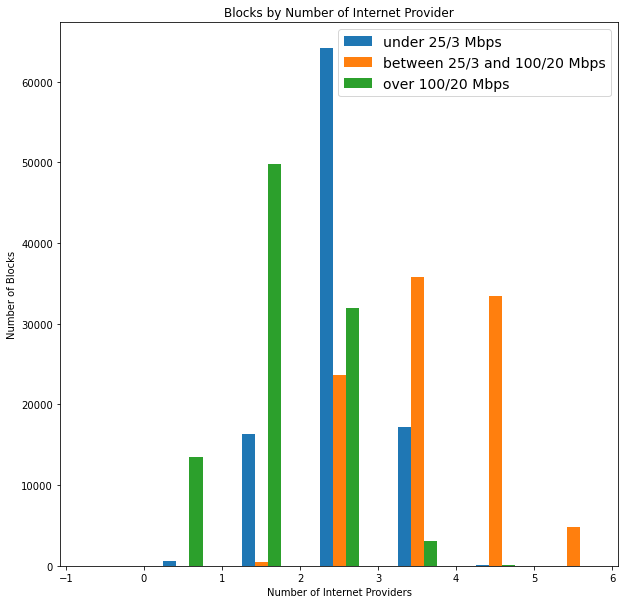

In [80]:
internet_types = ['under 25/3 Mbps','between 25/3 and 100/20 Mbps','over 100/20 Mbps']
plt.hist(fcc_blocks[['under 25/3 Mbps','between 25/3 and 100/20 Mbps','over 100/20 Mbps']],label=internet_types,bins=range(-1,8),rwidth=.5)
plt.title("Blocks by Number of Internet Provider")
plt.ylabel('Number of Blocks')
plt.xlabel('Number of Internet Providers')
plt.legend(prop={'size': 14})

In [27]:
fcc_blocks = fcc_blocks.reset_index()

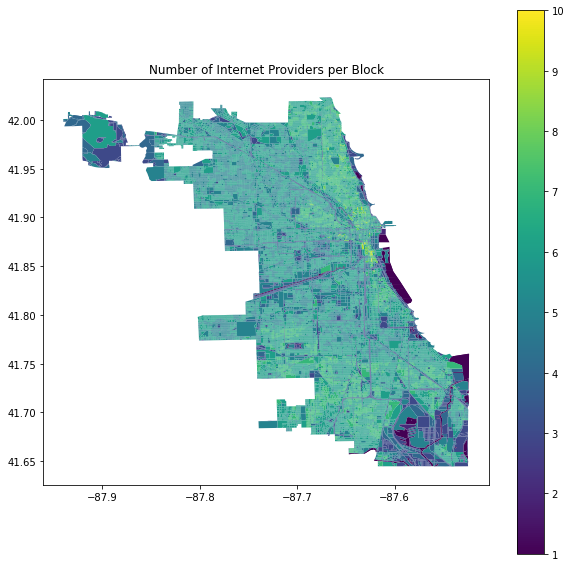

In [28]:
so.simple_map(fcc_blocks,'n_providers','block','Number of Internet Providers per Block')

In [29]:
# dummy variable for blocks with only satellite
fcc_blocks["only satellite"] = (fcc_blocks["satellite"] != 0) & (fcc_blocks["fixed wireless"] == 0) & (fcc_blocks["modern telephone (VDSL)"] == 0) & (fcc_blocks["modern cable (DOCSIS 3.0, 3.1)"] == 0) & (fcc_blocks["fiber"] == 0) & (fcc_blocks["other internet"] == 0)

# dummy variable for blocks with AT MOST sub-broadband
fcc_blocks["only under 25/3 Mbps"] = (fcc_blocks["under 25/3 Mbps"] != 0) & (fcc_blocks["between 25/3 and 100/20 Mbps"] == 0) & (fcc_blocks["over 100/20 Mbps"] == 0)

# dummy variable for blocks with AT MOST broadband
fcc_blocks["at least 25/3 but under 100/20 Mbps"] = (fcc_blocks["between 25/3 and 100/20 Mbps"] != 0) & (fcc_blocks["over 100/20 Mbps"] == 0)

# dummy variable for blocks with high-speed
fcc_blocks["at least 100/20 Mbps"] = (fcc_blocks["over 100/20 Mbps"] != 0)

In [30]:
print(f"percent of blocks with only satellite: {round(sum(fcc_blocks['only satellite'])/len(fcc_blocks)*100,1)}")
print(f"percent of blocks with less than 25/3 Mbps: {round(sum(fcc_blocks['only under 25/3 Mbps'])/len(fcc_blocks)*100,1)}")
print(f"percent of blocks with 25/3 to 100/20 Mbps: {round(sum(fcc_blocks['at least 25/3 but under 100/20 Mbps'])/len(fcc_blocks)*100,1)}")
print(f"percent of blocks with at least 100/20 Mbps: {round(sum(fcc_blocks['at least 100/20 Mbps'])/len(fcc_blocks)*100,1)}")

percent of blocks with only satellite: 11.1
percent of blocks with less than 25/3 Mbps: 0.0
percent of blocks with 25/3 to 100/20 Mbps: 13.7
percent of blocks with at least 100/20 Mbps: 86.3


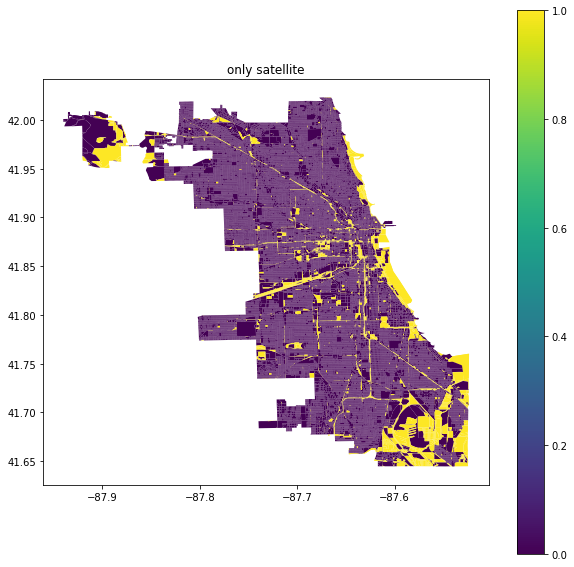

In [31]:
so.simple_map(fcc_blocks,'only satellite','block')

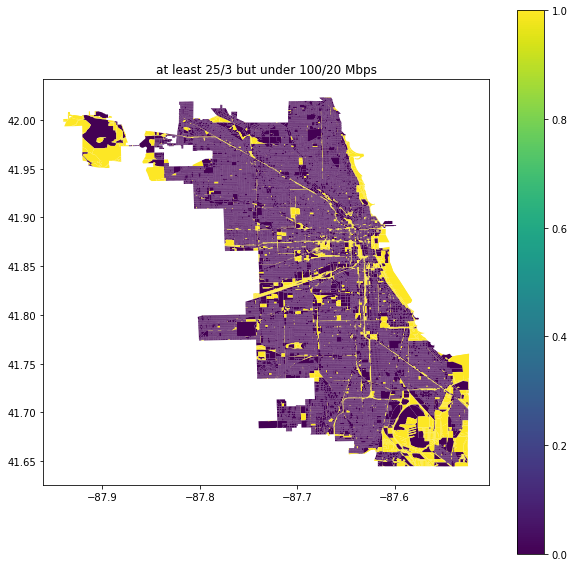

In [32]:
so.simple_map(fcc_blocks,'at least 25/3 but under 100/20 Mbps','block')

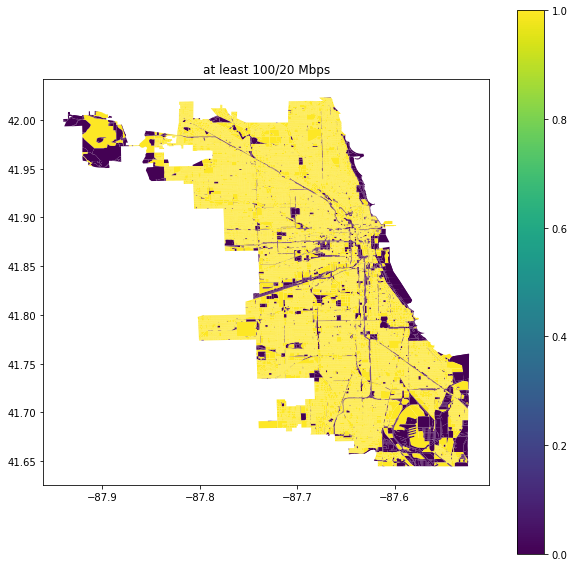

In [33]:
so.simple_map(fcc_blocks,'at least 100/20 Mbps','block')

The "only satellite" blocks appear to mostly be parks, highways, industrial areas, etc. Unsurprisingly this largely overlaps with blocks without any high-speed internet options. Later we can estimate the number of people living in these areas.

One implication of this to keep in mind: without doing a population-weighted mean, this means that tracts with more mostly non-residential areas will have a lower proportion of blocks with high-speed/non-satellite internet.

In [34]:
fcc_grouptract = fcc_blocks.groupby('tract')

fcc_tracts = fcc_grouptract.mean().reset_index()

# drop block
fcc_tracts = fcc_tracts.drop(columns="block")

fcc_tracts

,tract,"legacy telephone (ADSL, asym xDSL)",satellite,fixed wireless,modern telephone (VDSL),"modern cable (DOCSIS 3.0, 3.1)",fiber,other internet,n_providers,under 25/3 Mbps,between 25/3 and 100/20 Mbps,over 100/20 Mbps,only satellite,only under 25/3 Mbps,at least 25/3 but under 100/20 Mbps,at least 100/20 Mbps
0,10100,1.225806,3.000000,0.032258,0.774194,2.677419,0.032258,0.000000,5.806452,2.225806,4.548387,0.967742,0.064516,0.0,0.064516,0.935484
1,10201,1.238806,3.000000,0.402985,0.805970,2.626866,0.014925,0.000000,6.343284,2.238806,4.865672,1.014925,0.000000,0.0,0.000000,1.000000
2,10202,1.160000,3.000000,0.080000,0.200000,2.400000,0.000000,0.000000,5.920000,2.160000,3.760000,0.960000,0.040000,0.0,0.040000,0.960000
3,10300,1.306122,3.000000,0.244898,0.734694,2.612245,0.000000,0.000000,6.102041,2.306122,4.673469,0.979592,0.020408,0.0,0.020408,0.979592
4,10400,1.129032,2.935484,0.580645,0.741935,2.387097,0.000000,0.000000,6.096774,2.096774,4.806452,0.967742,0.064516,0.0,0.096774,0.903226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1313,843700,1.016129,3.000000,0.274194,0.532258,1.370968,0.903226,0.000000,5.483871,2.016129,3.225806,1.854839,0.016129,0.0,0.032258,0.967742
1314,843800,1.000000,3.000000,0.619565,0.521739,0.934783,0.000000,0.000000,5.510870,2.000000,3.141304,0.934783,0.043478,0.0,0.065217,0.934783
1315,843900,1.017544,2.824561,0.491228,0.543860,0.666667,0.017544,0.000000,4.771930,1.929825,2.947368,0.684211,0.263158,0.0,0.350877,0.649123
1316,980000,0.174757,3.000000,0.368932,0.029126,0.155340,0.000000,0.009709,3.679612,1.184466,2.398058,0.155340,0.592233,0.0,0.844660,0.155340


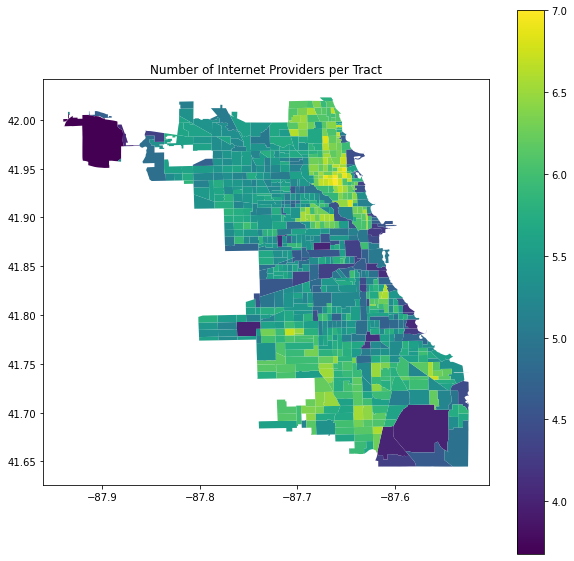

In [35]:
so.simple_map(fcc_tracts,'n_providers','tract','Number of Internet Providers per Tract')

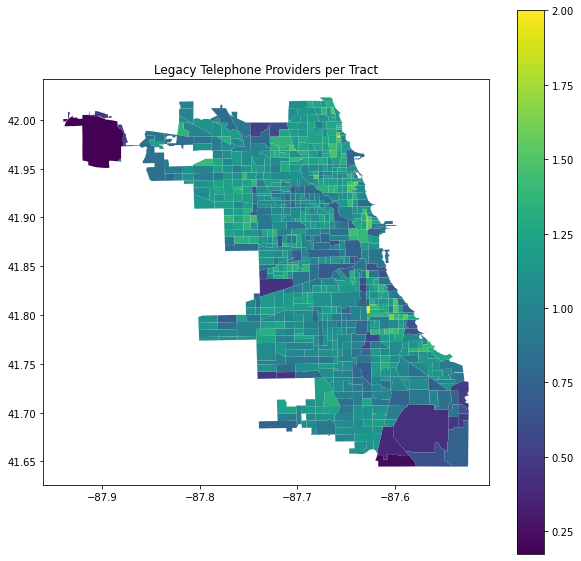

In [36]:
so.simple_map(fcc_tracts,'legacy telephone (ADSL, asym xDSL)','tract','Legacy Telephone Providers per Tract')

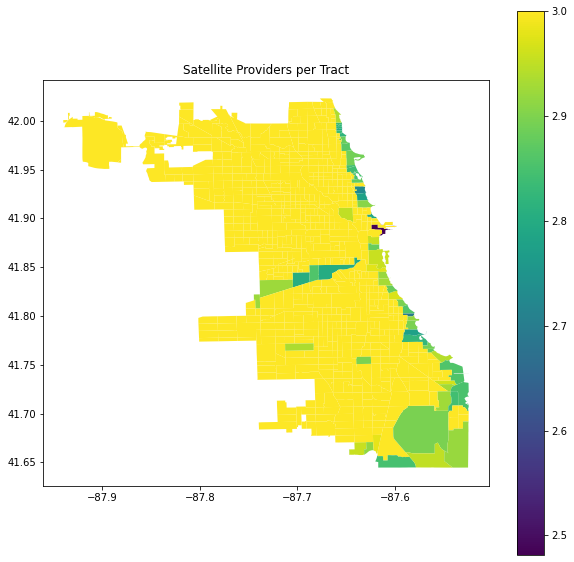

In [37]:
so.simple_map(fcc_tracts,'satellite','tract','Satellite Providers per Tract')


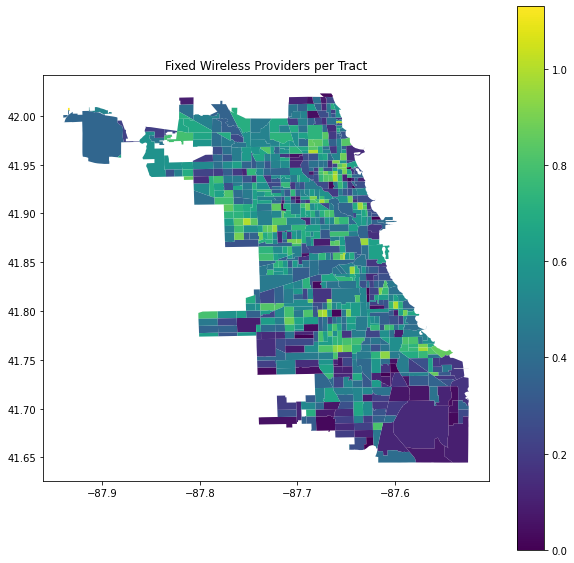

In [38]:
so.simple_map(fcc_tracts,'fixed wireless','tract','Fixed Wireless Providers per Tract')

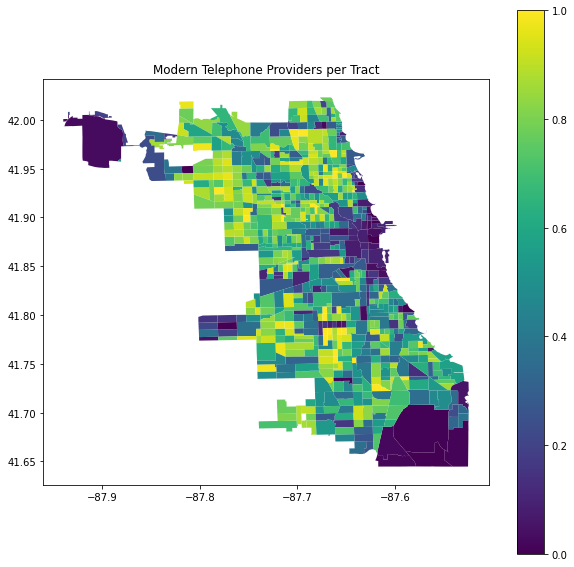

In [39]:
so.simple_map(fcc_tracts,'modern telephone (VDSL)','tract','Modern Telephone Providers per Tract')

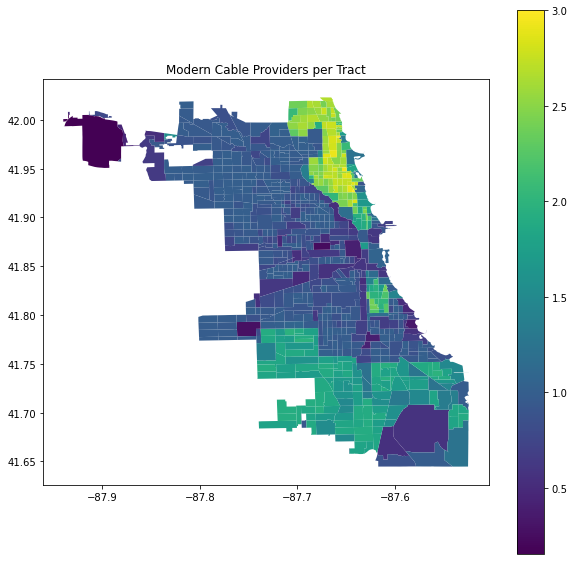

In [40]:
so.simple_map(fcc_tracts,'modern cable (DOCSIS 3.0, 3.1)','tract','Modern Cable Providers per Tract')

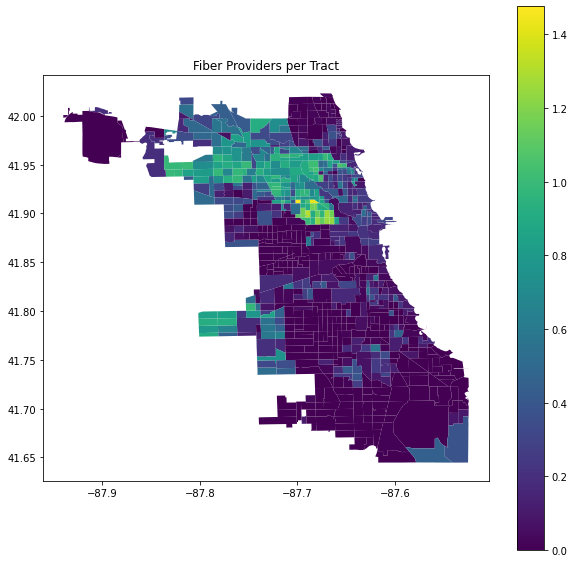

In [41]:
so.simple_map(fcc_tracts,'fiber','tract','Fiber Providers per Tract')


One finding to note: these maps help explain why almost all of the city has at least one high-speed (over 100/20 Mbps) internet option. In particular, a large portion of the South and West Side have a single modern cable provider that offers speeds above 100/20 Mbps. However, the lakeshore North Side has 2-3 modern cable providers (and a swath of the southern South Side has 2), while a significant portion of the inland North Side has fiber (unlike almost anywhere else in the city).

Now we're going to compare this to the census responses.

In [42]:
acs19 = fetch_census.acs5_aggregate()
acs19

,estimated total population,estimated total with internet subscription,estimated total with no internet access,estimated total has no computer,state,county,tract
0,1825,392,149,149,17,31,630200
1,5908,1242,231,133,17,31,580700
2,3419,928,140,104,17,31,590600
3,2835,917,138,81,17,31,600700
4,1639,322,245,218,17,31,611900
...,...,...,...,...,...,...,...
1314,4088,1125,777,424,17,31,440101
1315,3473,1071,544,339,17,31,440102
1316,3012,1098,449,337,17,31,440202
1317,3634,888,223,195,17,31,460301


In [43]:
acs19["percent no internet"] = acs19['estimated total with no internet access']/acs19['estimated total population']*100

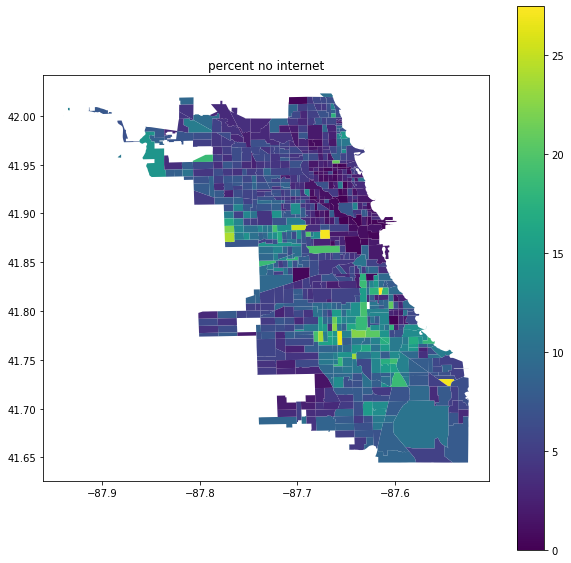

In [44]:
so.simple_map(acs19,'percent no internet','tract')

In [45]:
# don't rerun this line
fcc_tracts = fcc_tracts.merge(acs19,on="tract")
fcc_tracts

KeyError: "['only between 25/3 and 100/20 Mbps', 'only over 100/20 Mbps'] not in index"

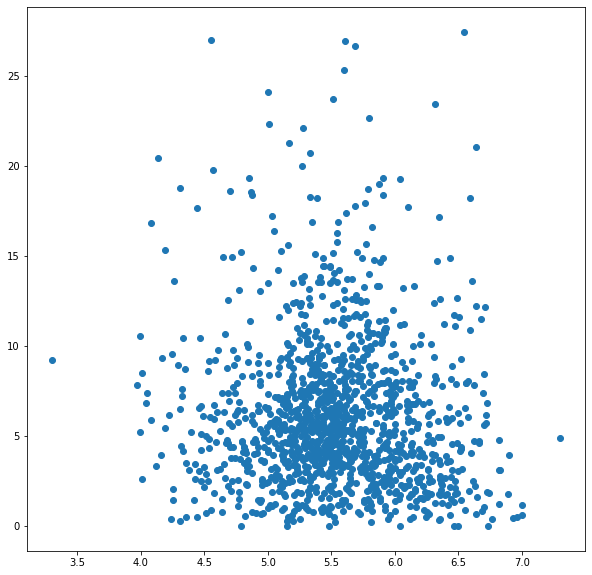

In [48]:
plt.scatter(fcc_tracts["n_providers"],fcc_tracts["percent no internet"])

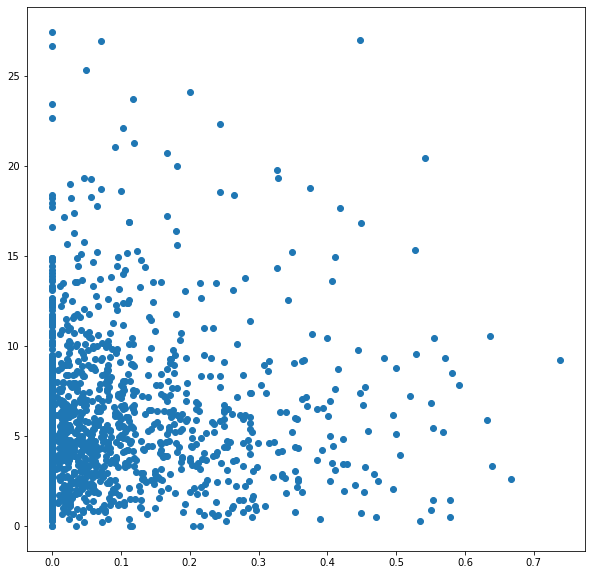

In [49]:
plt.scatter(fcc_tracts["only satellite"],fcc_tracts["percent no internet"])

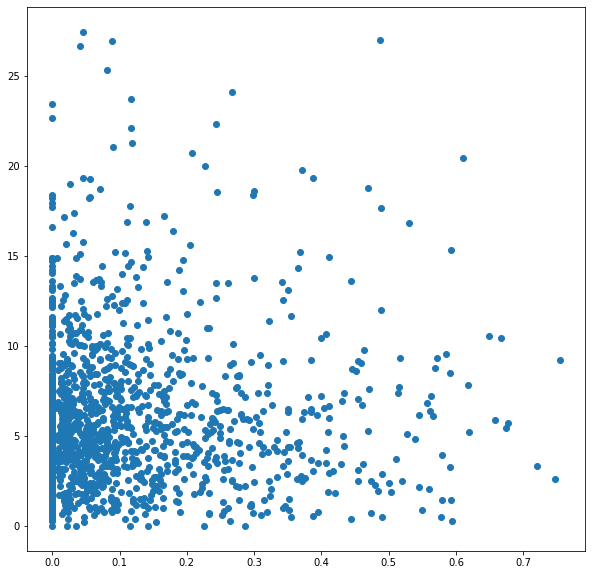

In [54]:
plt.scatter(fcc_tracts["at least 25/3 but under 100/20 Mbps"],fcc_tracts["percent no internet"])

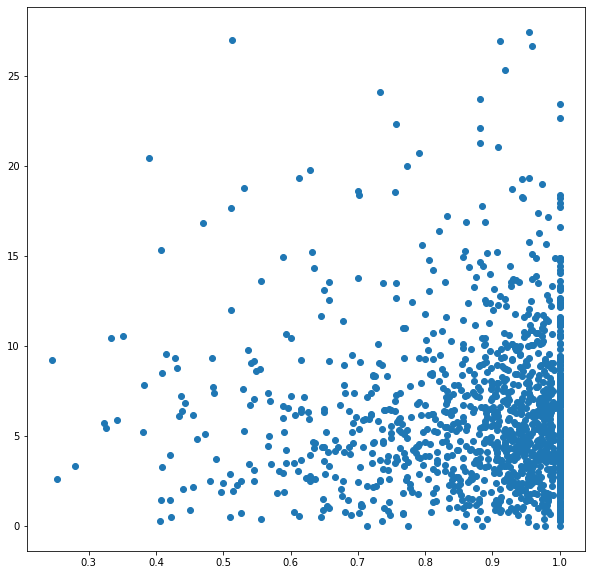

In [55]:
plt.scatter(fcc_tracts["at least 100/20 Mbps"],fcc_tracts["percent no internet"])


In [59]:
variables = {
    'legacy telephone (ADSL, asym xDSL)' : 'pop mean',
    'satellite' : 'pop mean',
    'fixed wireless' : 'pop mean',
    'modern telephone (VDSL)' : 'pop mean',
    'modern cable (DOCSIS 3.0, 3.1)' : 'pop mean',
    'fiber' : 'pop mean',
    'other internet' : 'pop mean',
    'n_providers' : 'pop mean',
    'under 25/3 Mbps' : 'pop mean',
    'between 25/3 and 100/20 Mbps' : 'pop mean',
    'over 100/20 Mbps' : 'pop mean',
    'only satellite' : 'pop mean',
    'only under 25/3 Mbps' : 'pop mean',
    'at least 25/3 but under 100/20 Mbps' : 'pop mean',
    'at least 100/20 Mbps' : 'pop mean',
    'estimated total population' : 'areal sum',
    'estimated total with internet subscription' : 'areal sum',
    'estimated total with no internet access' : 'areal sum',
    'estimated total has no computer' : 'areal sum',
}
fcc_community_area = so.aggregate(fcc_tracts,variables,'community_area','tract')
fcc_community_area

,community_area,"legacy telephone (ADSL, asym xDSL)",satellite,fixed wireless,modern telephone (VDSL),"modern cable (DOCSIS 3.0, 3.1)",fiber,other internet,n_providers,under 25/3 Mbps,between 25/3 and 100/20 Mbps,over 100/20 Mbps,only satellite,only under 25/3 Mbps,at least 25/3 but under 100/20 Mbps,at least 100/20 Mbps,estimated total population,estimated total with internet subscription,estimated total with no internet access,estimated total has no computer
0,ALBANY PARK,1.234577,3.000000,0.592851,0.627213,0.973295,0.500545,0.000000,5.548407,2.234577,3.181603,1.512301,0.015724,0.0,0.019828,0.980172,49961.187369,13540.175684,2679.856113,1808.666452
1,ARCHER HEIGHTS,1.177065,2.999787,0.650588,0.687191,0.915203,0.116249,0.002567,5.527776,2.179526,3.337671,1.031452,0.050878,0.0,0.081780,0.918220,13813.723726,2903.796993,777.277309,716.010379
2,ARMOUR SQUARE,0.839443,2.999909,0.442062,0.426796,0.629522,0.002828,0.002721,4.718409,1.842115,2.854834,0.646366,0.337485,0.0,0.381525,0.618475,13615.528727,3711.651911,1484.583788,1328.832660
3,ASHBURN,0.854391,3.000000,0.282088,0.556069,1.800844,0.327107,0.000000,5.981126,1.854391,2.838155,2.127954,0.029973,0.0,0.037735,0.962265,43495.864359,10482.281641,1849.160590,1282.853069
4,AUBURN GRESHAM,1.023092,3.000000,0.382825,0.702713,1.779864,0.111765,0.000000,6.117261,2.023092,3.086688,1.890479,0.037834,0.0,0.042266,0.957734,45990.553683,10410.330619,5288.812181,3438.812623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,WEST LAWN,1.140678,2.999997,0.256881,0.795795,1.763183,0.431614,0.000000,5.962453,2.140676,3.051198,2.196274,0.057600,0.0,0.061580,0.938420,31845.414894,7084.421501,1749.989696,1466.141022
73,WEST PULLMAN,1.085689,2.978084,0.288960,0.476049,1.724945,0.028744,0.000000,5.937989,2.074731,2.754050,1.753690,0.044682,0.0,0.048895,0.951105,30008.407859,8097.385146,2175.221780,1624.934467
74,WEST RIDGE,1.143443,3.000000,0.334991,0.594535,2.465237,0.010408,0.001085,6.226994,2.144528,4.449164,0.982793,0.018306,0.0,0.027615,0.972385,78422.464305,20863.402055,3674.066090,2197.782802
75,WEST TOWN,1.101726,2.999989,0.609526,0.694573,0.940981,0.963137,0.001100,6.075289,2.101722,3.254494,1.954838,0.055866,0.0,0.062093,0.937907,84703.719386,34028.114948,3202.776384,2541.177092


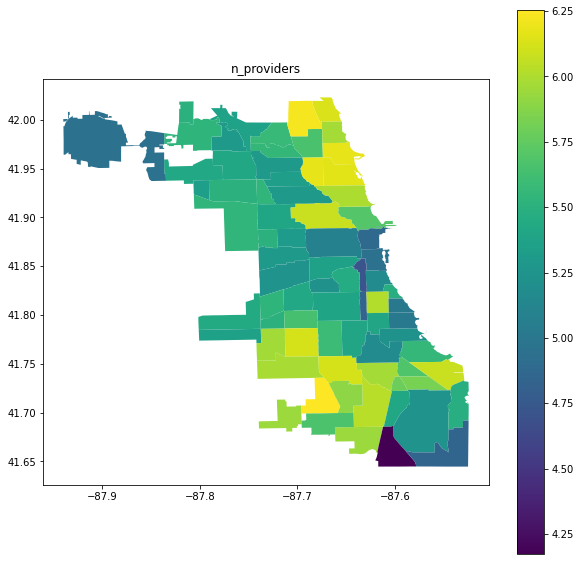

In [61]:
so.simple_map(fcc_community_area,'n_providers','community_area')

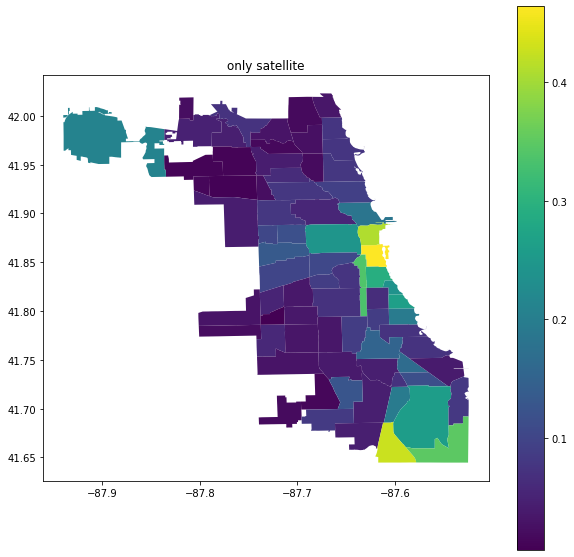

In [63]:
so.simple_map(fcc_community_area,'only satellite','community_area')

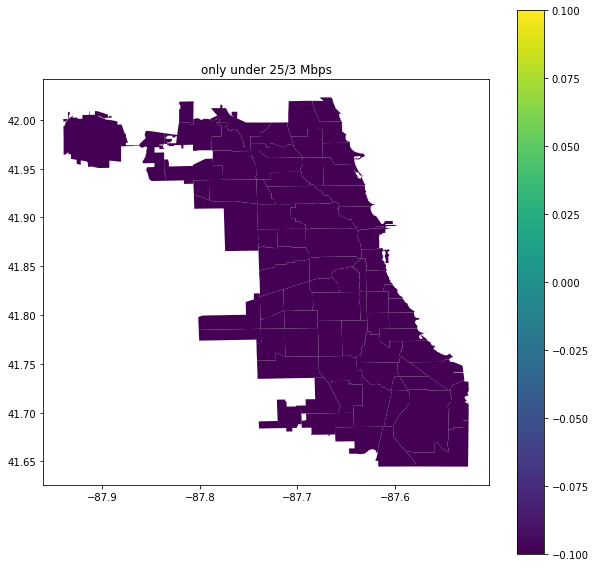

In [67]:
so.simple_map(fcc_community_area,'only under 25/3 Mbps','community_area')

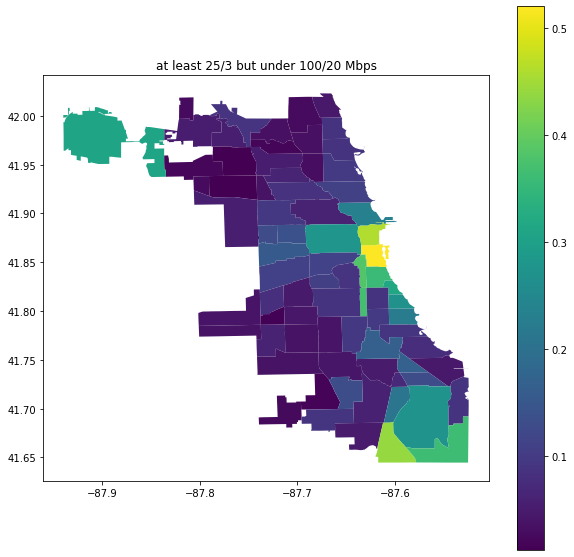

In [64]:
so.simple_map(fcc_community_area,'at least 25/3 but under 100/20 Mbps','community_area')

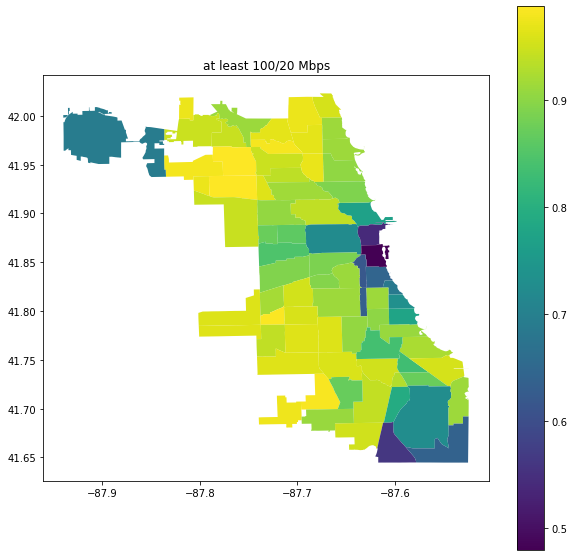

In [65]:
so.simple_map(fcc_community_area,'at least 100/20 Mbps','community_area')

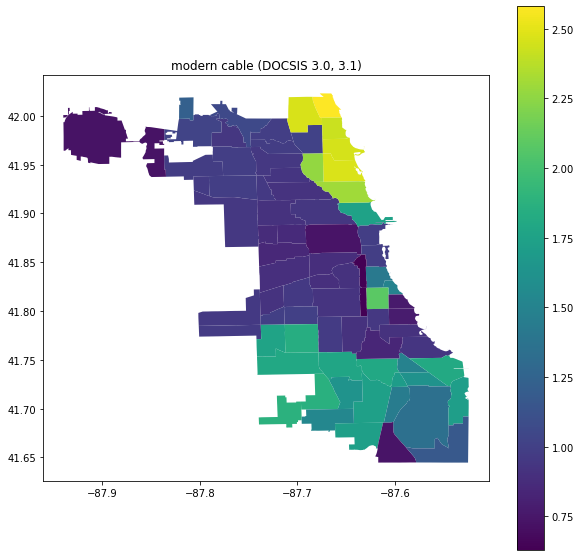

In [68]:
so.simple_map(fcc_community_area,'modern cable (DOCSIS 3.0, 3.1)','community_area')

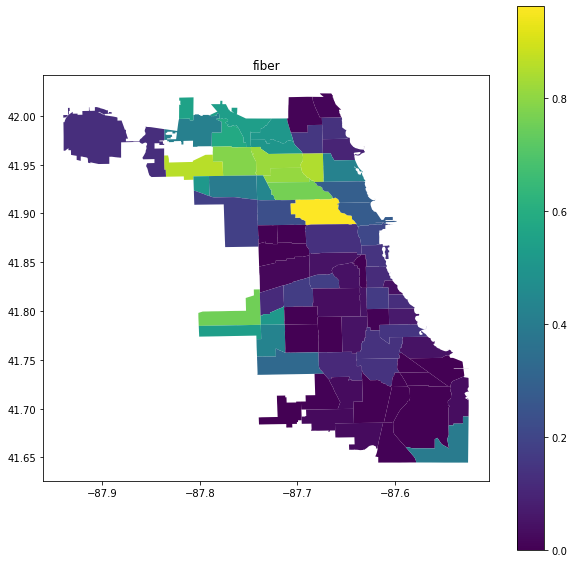

In [69]:
so.simple_map(fcc_community_area,'fiber','community_area')

In [71]:
fcc_community_area["number of high-speed internet options"] = fcc_community_area["modern cable (DOCSIS 3.0, 3.1)"] + fcc_community_area["fiber"]

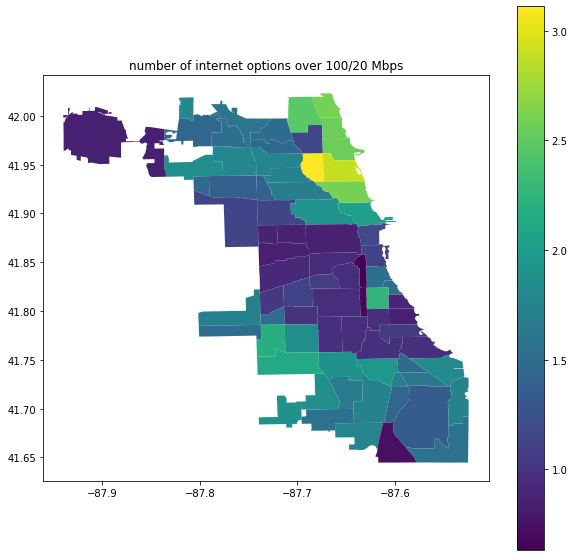

In [73]:
so.simple_map(fcc_community_area,'number of high-speed internet options','community_area','number of internet options over 100/20 Mbps')

##### [Old] Tract-level analysis

We have 1319 tracts with an average of ~480 data points per tract.

In [ ]:
fcc_grouped = chi_fcc.groupby(['tract'])
fcc_grouped.count()

In [ ]:
# We'll use median advertised speeds for tract aggregation (outliers less important)
fcc_tracts = fcc_grouped.median()
# also, we can drop the Consumer column at this point
fcc_tracts = fcc_tracts[["MaxAdDown","MaxAdUp"]]
fcc_tracts

In [ ]:
print(f"Median block advertised downstream speed: {fcc_tracts.MaxAdDown.median()} Mbps")
print(f"Median block advertised upstream speed: {fcc_tracts.MaxAdUp.median()} Mbps")

Let's look at some histograms of what the median advertised speed looks like.

In [ ]:
median_tract_down = plt.hist(fcc_tracts.MaxAdDown,bins=range(0,120,1))

In [ ]:
median_tract_up = plt.hist(fcc_tracts.MaxAdUp,bins=range(0,10,1))

That's not very exciting. It is fairly interesting, though, in that it demonstrates the very large majority of Chicago tracts have pretty much the same median advertised speed.

How much variation at a block level are we losing with our median estimates?

In [ ]:
# this are all block/technology/providers
median_block_down = plt.hist(chi_fcc.MaxAdDown,bins=range(0,1500,10))

Answer: A lot, clearly! 

A final note: It would be nice to have access to the FCC's Fixed Broadband Subscription data, which they also require to be filed and which lists the actual # of customers. But it's not publicly available.

Also note that the FCC's map of Form 477 Broadband Deployment is quite nice: https://broadbandmap.fcc.gov/#/location-summary?version=dec2020&lat=41.789403&lon=-87.599576&tech=acfosw&speed=25_3&vlat=41.78958400043072&vlon=-87.599651&vzoom=18.74542480573349

In [ ]:
test = pd.read_csv('data/chicago_internet.csv')

In [ ]:
test["community_area"]=[i.upper() for i in test["name"]]
test

In [ ]:
so.simple_map(test,'hh_internet(%)','community_area','Percent of Households with Internet by Community Area')